# Measurement of a 1D Profil


In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from main import measure, GAMMA
from helper import view, view_phase
import numba_ft

# Setup
## Load the sample2
This time the sample consists of two sub-samples with different $T_1$ and $T_2$.
They resemble oil and water. 
Two different versions of sample2 can be loaded. 
1. `sample2.npy` Size $100 \times 100$  
2. `sample2_modi.npy`Size $300 \times 300$  
The second one takes a lot longer to simulate but the result resembles the reality far better.
In this notebook the second one will be used but feel free to change to the first one.

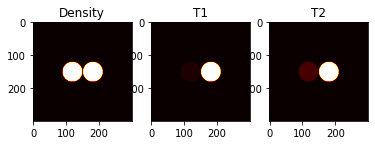

In [2]:
sample_file = "sample2_modi.npy"
sample = np.load(f"{os.getcwd()}/{sample_file}")
view(sample)

Another important aspect is the size of the sample and a value for scaling real-world values to the simulation.
The real-world sample has a diameter of around $2.5\,$mm. In the simulation this corresponds to either $20\,$px or $60\,$px radius.
Therefore, the scale factor is given by:
$$\eta = \frac{2.5\,\text{mm}}{20\,\text{px}} = 0.125\,\frac{\text{mm}}{\text{px}} = 125e-6\,\frac{\text{m}}{\text{px}},$$
or
$$\eta = \frac{2.5\,\text{mm}}{60\,\text{px}} = 0.042\,\frac{\text{mm}}{\text{px}} = 42e-6\,\frac{\text{m}}{\text{px}}.$$

In [3]:
if sample_file == "sample2.npy":
    scale = 25e-5 # 125e-6
elif sample_file == "sample2_modi.npy":
    scale = 42e-6
else:
    raise ArithmeticError("Unkown scaling!")

## Setup magnetic field
It is necessary to add some noise to the magnetic field. Otherwise, the magnetic
field will be perfectly homogenous, which is unrealistic. Furthermore, is a slight
inhomogeneity in the magnetic field necessary for spin echos.

In [4]:
b0_homo = np.zeros(sample.shape[:2])
b0_homo.fill(0.43)
b0 = b0_homo + np.random.normal(0, 1e-6, b0_homo.shape)

f_larmor = GAMMA * 0.43

Setup phases and measurement time

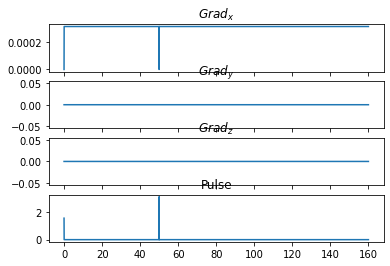

In [5]:
tfactor = 100  # how many steps per 1ms
echotime = 50  # ms
t = 3 * echotime + 10

# phases = [Gradx, Grady, Gradz, Pulse]
ts = np.linspace(0, t, t * tfactor)
phases = np.zeros((t * tfactor, 4))

# gradient in x
phases[:, 0] = 7.5 * scale  # 75 mT/m 

# pulses
phases[0, 3] = np.pi / 2
phases[0, 0] = 0  # remove gradient at 90 degree puls

phases[tfactor * echotime, 3] = np.pi
phases[tfactor * echotime, 0] = 0  # remove gradient at 180 degree puls

get = list(range(tfactor * echotime, 3 * tfactor * echotime))



view_phase(phases, tfactor)

# Measurement & Results
## Measurement with gradient along x

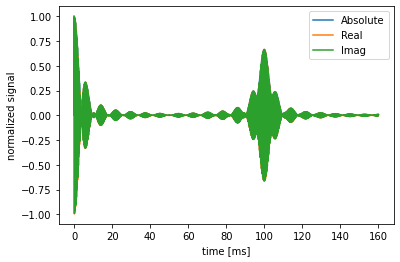

In [6]:
signal = measure(sample, b0, tfactor, phases, f_larmor)
plt.plot(ts, np.abs(signal), label="Absolute")
plt.plot(ts, np.real(signal), label="Real")
plt.plot(ts, np.imag(signal), label="Imag")
plt.xlabel("time [ms]")
plt.ylabel("normalized signal")
plt.legend()
plt.show()


This signal is Fourier-Transformed. The signal peak closest do 0 is examined. Therefore, the image bellow shows more than necessary and is zoomed in to the peak (closest to zero).

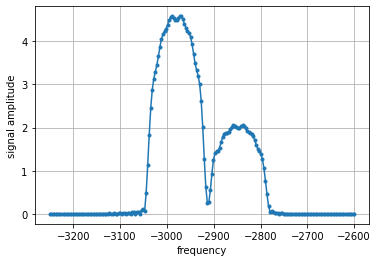

In [7]:
f = np.linspace(-3250, -2600, 200, True)
times = np.array([e / tfactor * 1e-3 for e in get])
fft_signal = np.abs(numba_ft.ft_uneven(signal[get], times, 2 * np.pi * f, 1, 0))
plt.plot(f, fft_signal, ".-")
plt.xlabel("frequency")
plt.ylabel("signal amplitude")
plt.grid()
plt.show()

If version `sample2.npy` was used: This result is a litte bit unfortunate. It looks like two gaussian peaks.
Due to the cyclic form of the sample another result would be better.

The accuracy here is limited to the size we "draw" the sample on. The created
sample has a size of $100\times100$ in total. Both circles, each have a radius of 10 array slots.
Therefore, the image is washed out.

## Measurement with gradient along y

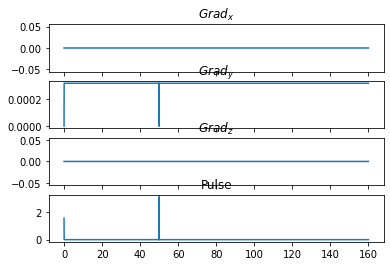

In [8]:
# remove gradient in x
phases[:, 0] = 0

# gradient in y
phases[1:, 1] = 7.5 * scale  # 150 mT/m 
phases[tfactor * echotime, 1] = 0
view_phase(phases, tfactor)

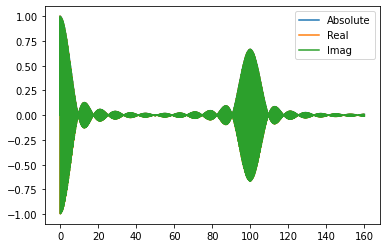

In [9]:
signal = measure(sample, b0, tfactor, phases, f_larmor)
plt.plot(ts, np.abs(signal), label="Absolute")
plt.plot(ts, np.real(signal), label="Real")
plt.plot(ts, np.imag(signal), label="Imag")
plt.legend()
plt.show()

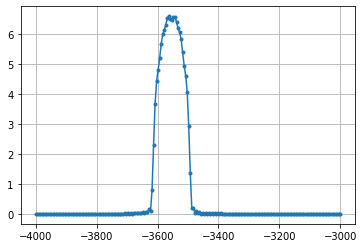

In [10]:
f = np.linspace(-4000, -3000, 200, True)
times = np.array([e / tfactor * 1e-3 for e in get])
fft_signal = np.abs(numba_ft.ft_uneven(signal[get], times, 2 * np.pi * f, 1, 0))
plt.plot(f, fft_signal, ".-")
plt.grid()
plt.show()

If we measure in y direction we get a single signal.
Comparing the amplitude we find an amplitude close to the sum of the amplitudes of the signals before.
This is as we expected as the spins along the x direction "feel" the same magnetic field (ignoring the noise).